In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## Introduction

This notebook guides you through the process of creating a basic churn prediction model. The model is build from the Accountant App Dataset from file `Dataset - AccountantApp.xlsx`.

## Load Data into Pandas DataFrame

We will use Pandas as our main data analysis tool for this work. First, we load the `Dataset - AccountantApp.xlsx` into a Pandas DataFrame.

In [2]:
cols = ['Id', 'Registration Date', 'Email Domain', 'Acquisition Channel',
       'Location', 'Invoices Created', 'Price Quotations Created',
       'Initial Contact', 'Blog Visits', 'Additional users',
       'Downloaded Reports', 'Is Legal Entity', 'Requested help',
       'Purchase interest']

df = pd.read_excel('Dataset - AccountantApp.xlsx', usecols=cols)

A sample of the DataFrame (`df`) is shown below.

In [3]:
df.head()

,Id,Registration Date,Email Domain,Acquisition Channel,Location,Invoices Created,Price Quotations Created,Initial Contact,Blog Visits,Additional users,Downloaded Reports,Is Legal Entity,Requested help,Purchase interest
0,196981,2018-12-12,corporate,Traditional Channel,Urban,0,0,0,0,0,0,0,1,1
1,196824,2018-12-12,corporate,Traditional Channel,Rural,0,0,0,0,2,0,0,0,1
2,198450,2018-12-19,hotmail,Traditional Channel,Rural,0,0,0,4,1,0,0,0,1
3,199043,2018-12-21,corporate,Traditional Channel,Urban,0,0,0,6,0,0,0,0,1
4,198216,2018-12-17,corporate,Traditional Channel,Urban,0,0,0,0,0,0,0,0,1


## Data cleaning
Next, we clean the data from `Null` and `NaN` values the `df` may contain. We use the functions

```python
df.isnull()
df.isna()
```

to look for this values. Fortunatelly, this data is in good shape and we don't have any of these problematic values, as you can se below in the heatmap plots. If there where any `Null` or `NaN` value, the heatmap will show these as yellow thin lines.

<AxesSubplot:>

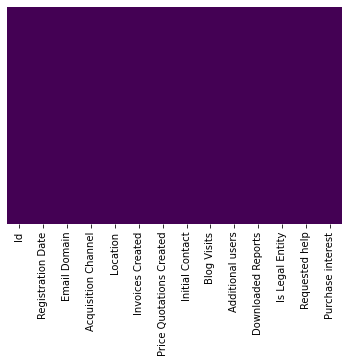

In [4]:
# check for null values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis') 

<AxesSubplot:>

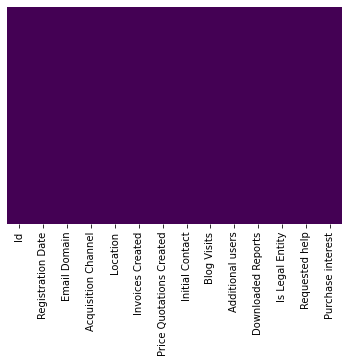

In [5]:
# check for null values
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='viridis') 

## Data exploration

This first section will focus on exploring the data and se whether or not these are good indicators of a potential customer.

First, let's look at the `Purchase interest`.

In [15]:
sns.set_style('whitegrid')

[Text(0, 0.5, 'Percent')]

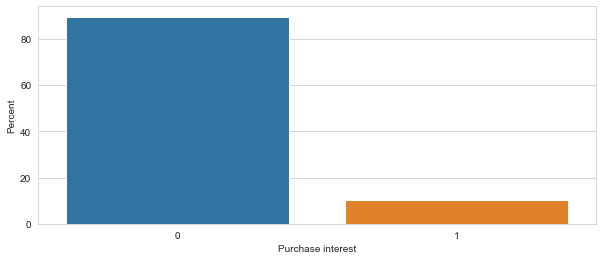

In [16]:
# lets do some exploratory analysis
plt.figure(figsize = (10,4))
# sns.countplot(x='Purchase interest', data=df)
ax = sns.barplot(x='Purchase interest', y='Purchase interest', data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

We see that most of the companies, around 90%, decided not to pay for the App after the trial period. While for the reamined 10%, they where conviced and decided to pay for the App.

Let's know focus on how to know if a feature is a good indicator of a possible client. To do that we're going to usea the **conditional probability** which means given a feature whats the probability that company will acquire the App.

We first look at the feature `Invoices Created` which is the most important according to documentation. This parameters is a bit messy at the high end so we decided to take values up to 500. Below you can see the density distribution of this truncated parameter.

/Users/omar/opt/miniconda3/envs/nimble/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


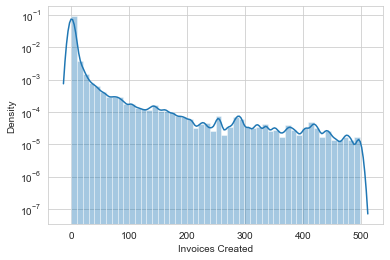

In [84]:
ax = sns.distplot(df['Invoices Created'][df['Invoices Created'] < 500])
ax.set_yscale('log')

Next is to group by this `Invoices Created` parameter and take the mean on `Purchase interest` values that we called `churnLabel` and which is what we care at the end. The result is stored in a new DataFrame called `dfC`.

In [150]:
dfC = df[df['Invoices Created'] < 150].groupby('Invoices Created', as_index=False)['Purchase interest'].mean()
dfC.columns = ['Invoices Created', 'churnLabel']
dfC.head()

,Invoices Created,churnLabel
0,0,0.031885
1,2,0.094838
2,4,0.170714
3,6,0.231162
4,8,0.236742


If we plot this result we get a clear tendency that shows what we kind of expect, the more invoices created the more probability the company to get on board. We also fit the data to a quadratic function to get a clean sample of this behaviour showing more details. The shade region around the fit shows the 95% confidence value. With the fit, we realize that more invoices also brings more variance mostly due the low amount of data, and we see the probability to get on board start to decrease a bit.

<AxesSubplot:xlabel='Invoices Created', ylabel='churnLabel'>

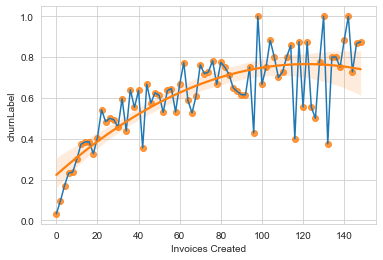

In [151]:
sns.lineplot(x='Invoices Created', y='churnLabel', data=dfC)
sns.regplot(x='Invoices Created', y='churnLabel', data=dfC, order=2)

We're going to test more parameters using this **conditional probability** model. For simplicity, we create a function called `churnPlot` that does all above.

In [130]:
def churnPlot(param, parlim, order=2):

    if parlim is not None:
        dfC = df[df[param] < parlim].groupby(param, as_index=False)['Purchase interest'].mean()
    else:
        dfC = df.groupby(param, as_index=False)['Purchase interest'].mean()

    dfC.columns = [param, 'churnLabel']
    dfC.head()

    sns.lineplot(x=param, y='churnLabel', data=dfC)
    sns.regplot(x=param, y='churnLabel', data=dfC, order=order)

Our next parameter is the `Registration Date`, however, to get a cleaner sample we're going to take the month only and create a new column called `Registration Month`.

In [136]:
# create new column with the registration month
df['Registration Month'] = df['Registration Date'].dt.month

On the contrary to `Invoices Created`, `Registration Month` is a poor indicator for a company to get on board. The highest probability is below 12% around October and January.

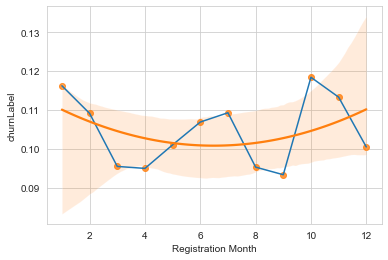

In [137]:
churnPlot('Registration Month', None)

The next plots show `churnPlot` results for `Price Quotations Created`, `Blog Visits`, `Downloaded Reports` and `Requested help`. All of these prove to be good indicators for a potential paying user with highest probabilities at around 80% or more.

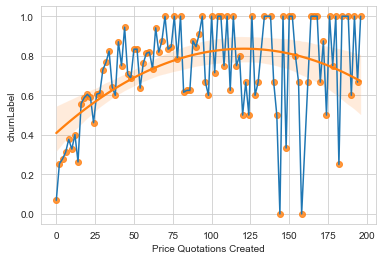

In [123]:
churnPlot('Price Quotations Created', 200)

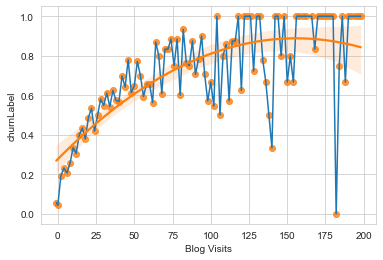

In [124]:
churnPlot('Blog Visits', 200)

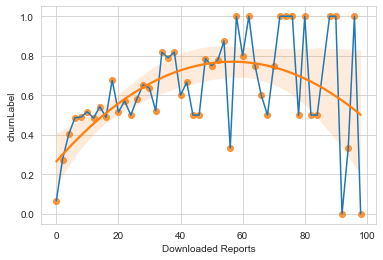

In [126]:
churnPlot('Downloaded Reports', 100)

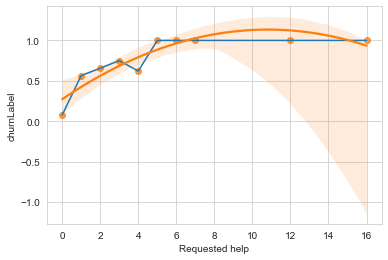

In [134]:
churnPlot('Requested help', None, 2)

There's more data to explore, however, the remained is a categorical or binary kind and therefore there's no need for a conditional probability. Instead, we plot counts of the subcategories for the reamined parameters again `Purchase interest`.

We start with `Email Domain`. It seems that `hotmail` and `corporate` domains are good indicators, specially `corporate` where a third of comapnies with this domain end up paying for the App while `hotmail` gets around 1/10. 

<AxesSubplot:xlabel='Purchase interest', ylabel='count'>

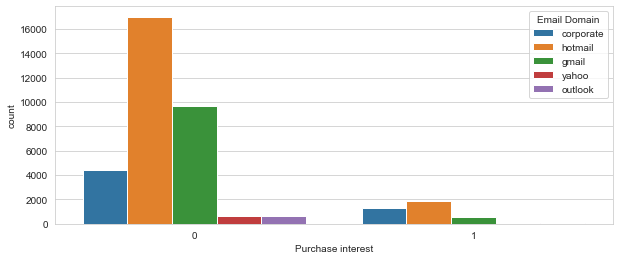

In [8]:
plt.figure(figsize = (10,4))
sns.countplot(x='Purchase interest', hue='Email Domain', data=df)

Next is `Acquisition Channel`. Here is obvious that `Alternative Channel` nor `Referral` brings potential customers.

<AxesSubplot:xlabel='Purchase interest', ylabel='count'>

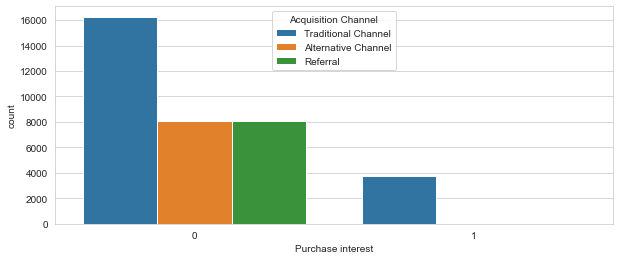

In [9]:
plt.figure(figsize = (10,4))
sns.countplot(x='Purchase interest', hue='Acquisition Channel', data=df)

`Location` shows an interest behaviour. Even though `Rural` companies dominate over `Urban` companies, at the end, both get almost the same number of enrrollment.

<AxesSubplot:xlabel='Purchase interest', ylabel='count'>

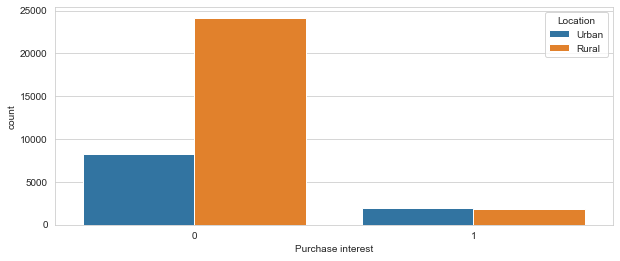

In [10]:
plt.figure(figsize = (10,4))
sns.countplot(x='Purchase interest', hue='Location', data=df)

Companies that received an initial contact are most liekely to enroll than those that do not.

<AxesSubplot:xlabel='Purchase interest', ylabel='count'>

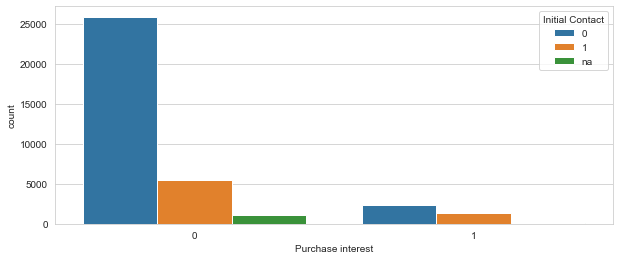

In [138]:
plt.figure(figsize = (10,4))
sns.countplot(x='Purchase interest', hue='Initial Contact', data=df)

Another interesting behaviour. If companies add 1 or more `Additional users`, it's highly likely that they end up paying for the App.

<AxesSubplot:xlabel='Purchase interest', ylabel='count'>

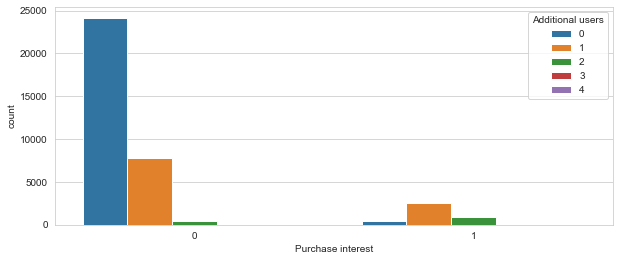

In [144]:
plt.figure(figsize = (10,4))
sns.countplot(x='Purchase interest', hue='Additional users', data=df)

## Strategies to bring potential customers

From the data exploration and the conditional probability model above, we propose the following strategies to improve the conversion rate from non-paid to paying user.

### 1. Increase of trial period

From conditional probability of `Invoices created`, we see a relation between potential customers and the number of invoices created by user. The more invoices the user create, the more likely to become a paying user. The decrease behaviour at a very number of invoices creates is due the few data available at that scale. Therefore, a good strategy will be to increase the trial period to left more time for users to create more invoices increasing the probability to become a paying user.

Take for instance companies that created two invoices within the trial period. These represent 9.2 % out of the total users and have a probability of being paying user of around 9.5%. 

In [171]:
print('Number of companies that created 2 invoices with the App within the trial period: %i (%.1f%%)' 
%(sum(df['Invoices Created'] == 2), 100 * sum(df['Invoices Created'] == 2) / len(df)))

dfC = df[df['Invoices Created'] < 150].groupby('Invoices Created', as_index=False)['Purchase interest'].mean()
dfC.columns = ['Invoices Created', 'churnLabel']
dfC[dfC['Invoices Created'] == 2]

Number of companies that created 2 invoices with the App within the trial period: 3332 (9.2%)


,Invoices Created,churnLabel
1,2,0.094838


If we double the trial period time, then the companies will tend to double the number of invoices created, that is from 2 to 4 in our example. This means that from the 9.2% or the 3332 users, around 315 will pay for the App at the end of the trial period, but it will increase to 565 users if trial perdiod is doubled.

In [173]:
dfC[dfC['Invoices Created'] == 4]

,Invoices Created,churnLabel
2,4,0.170714


### 2. Increase interaction with users

From `Requested help` and `Initial Contact` data exploration, it seems the interaction between the team and the users is key to have them on board. If at least one user requst help, its probability to become a paying user increase to more than 50% compared to users that never requested help with probability of nearly zero. The probability of user that had an initial contact from team is not as hihgh as for `Requested help` but it of the order of 20% which is not bad.

If promotions towars an initial contact are made, users will tend to end up paying for the App at the end of trial period.

### 3. More advertising towars winter season

Previously we saw that conditional probability of `Registration Month` does not seem to be a good indicator for a potential company to enroll. However, it shows a tendency with a higher probability towars the winter season possibly due tax management at the end of the year or christmass bonus being arranged from companies.
With that in mind, its likely to see an increase in companies enrolled if advertising increase around the months of November and December.

### 4. Stop non-traditional acquisitions channels

We show how `Alternative Channel` and `Referral` acquisitions channels are useless as these brings almost zero potential customers. Efforts towars these channels can be redirected towars other strategies such as increase the task forces in `Urban` areas where the probability to get customers is higher than in `Rural` areas.

## Building a predictive model

In order to predict the values we need for our model and strategies above, we're going to use one of the mostly commonly used machine learning algorithms in industry: random forest. Random forests have proven to be incredibly successful for all types of problems over the last 10 or so years. Briefly however, here are some of the virtues of a random forest:
* Data does not have to be linearly separable (unlike linear SVM or other linear classifiers)
* Data doesn't need to be normalised
* Massively scalable for training
* Hard to overfit
* Works with continuous and categorical data (more about this later)

Additionally, historically random forest have always performed well in churn prediction tasks.


### Preparing data for ML model

A good way to check whether any particular column needs to be modified or not is by looking at the column data type with `dtypes`. Here `object`, `str` or `datetime` types need to be removed or transformed.

In [185]:
df.dtypes

Id                                   int64
Registration Date           datetime64[ns]
Email Domain                        object
Acquisition Channel                 object
Location                            object
Invoices Created                     int64
Price Quotations Created             int64
Initial Contact                     object
Blog Visits                          int64
Additional users                     int64
Downloaded Reports                   int64
Is Legal Entity                     object
Requested help                       int64
Purchase interest                    int64
Registration Month                   int64
dtype: object

For instance, column `Initial Contact` despite being binary column according to documentation, it appears as `object`, meaning there's something else that is not an `int` type.

We can check the unique values of a column using the `set` function.

In [186]:
print('Whats causing this column to be an object type?')

print('Lets see the unique values:')
print(set(df['Initial Contact']))

print('... and, how many na values we have?')

print('Answer: %i' %(sum(df['Initial Contact'] == 'na')))

Whats causing this column to be an object type?
Lets see the unique values:
{0, 1, 'na'}
... and, how many na values we have?
Answer: 1187


We where right, there's a non expected string value, `na`, responsible for this column to be an `object` type. We don't want to get rid of the 1187 rows with this `na` values, instead, let's assign the value 0, meaning these did not get an initial contact like the vast majority as we can see from plot below.

<AxesSubplot:xlabel='Initial Contact', ylabel='count'>

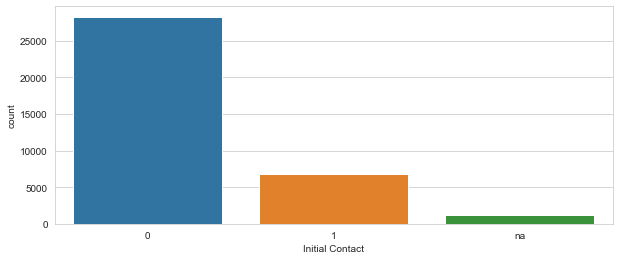

In [187]:
plt.figure(figsize = (10,4))
sns.countplot(x='Initial Contact', data=df)

To apply the substitution of `na` for `0` integer, we change the data type of the entire colum to strings and then implement the next lambda function:

```python
lambda x: 0 if x == '0' else 1
```

More `na` values where found in `Is Legal Entity` column, whose entries where not binary as the documentation says, besides `na`, it includes the following unique values:

```python
set(df['Is Legal Entity'])
    {0, 1, 10, 11, 12, 13, 15, 16, 19, 2, 23, 25, 3, 4, 5, 6, 7, 8, 9, 'na'}
```

Below we implement the lambda transformation to `Initial Contact` and `Is Legal Entity`, and create a new column called `Registration Month` where we keep the month (number) only from the `Registration Date` as this integer may be an useful feature for the model.

In [188]:
# create new column with the registration month
df['Registration Month'] = df['Registration Date'].dt.month

# Replace na values with zeroes and ones to values greather than 1
df['Initial Contact'] = df['Initial Contact'].astype(str).apply(lambda x: 0 if x == '0' else 1)

# Replace na values with zeroes and ones to values greather than 1
df['Is Legal Entity'] = df['Is Legal Entity'].astype(str).apply(lambda x: 0 if x == '0' else 1)

The remain `object` type columns we need to take care are `Email Domain`, `Acquisition Channel` and `Location`. Information within these columns can be easily transformed to `Integer` type using the pandas `get_dummies` built in function.

Finally, we concatenate the new data to the DataFrame and drop the columns we do not need anymore

```python
['Id', 'Registration Date', 'Email Domain', 'Acquisition Channel', 'Location']
```

In [189]:
domains = pd.get_dummies(df['Email Domain'])
channel = pd.get_dummies(df['Acquisition Channel'])
isurban = pd.get_dummies(df['Location'], drop_first=True)

df = pd.concat([df, domains, channel, isurban], axis=1)

In [190]:
df.drop(['Id','Registration Date', 'Email Domain', 'Acquisition Channel', 'Location'], axis=1, inplace=True)

If we check the DataFrame data types again, we can see they're `int` type only which is what we need for our ML model.

In [191]:
df.dtypes

Invoices Created            int64
Price Quotations Created    int64
Initial Contact             int64
Blog Visits                 int64
Additional users            int64
Downloaded Reports          int64
Is Legal Entity             int64
Requested help              int64
Purchase interest           int64
Registration Month          int64
corporate                   uint8
gmail                       uint8
hotmail                     uint8
outlook                     uint8
yahoo                       uint8
Alternative Channel         uint8
Referral                    uint8
Traditional Channel         uint8
Urban                       uint8
dtype: object

### The model: Random Forest

Now we separate our data into features $X$ and the prediction value $y$, then into the train and test sets. Luckily for us there is a function in sklearn which randomly splits our data into a train and test set for us.

In [232]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [233]:
X = df.drop(['Purchase interest'], axis=1)
y = df['Purchase interest']

# we take a 20 per cent test sample and 80 per cent train sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Conventionally we refer to the feature set as $X$ and the labels as $y$. In the above test train split we have allocated 80% of our dataset for training and 20% for testing.

Then we define our model,

In [244]:
model = RandomForestClassifier(n_estimators=100)

and finally we fit our model...

In [245]:
model.fit(X_train, y_train)

RandomForestClassifier()

Now that our model has been trained we can assess its performance on our test data set. We get the predictions from the `X_test` sample and compute the `confusion matrix` and `classification report` using the built in functions in sklearn.

In [246]:
predictions = model.predict(X_test)

In [249]:
confusion_matrix(y_test, predictions)

array([[6308,  173],
       [ 222,  543]])

In [250]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6481
           1       0.76      0.71      0.73       765

    accuracy                           0.95      7246
   macro avg       0.86      0.84      0.85      7246
weighted avg       0.94      0.95      0.94      7246



### Feature importance

A useful feature of random forests is that we can look at the *feature importances*, this is related to the amount of information gain we get from each feature. Let's have a look at the top 10 features of our model:

In [231]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature --> %s --> (%f)" % (f + 1, list(X_train.columns)[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature --> Invoices Created --> (0.203823)
2. feature --> Blog Visits --> (0.173421)
3. feature --> Additional users --> (0.099410)
4. feature --> Registration Month --> (0.096281)
5. feature --> Traditional Channel --> (0.086147)
6. feature --> Price Quotations Created --> (0.072475)
7. feature --> Downloaded Reports --> (0.056064)
8. feature --> Requested help --> (0.053012)
9. feature --> Urban --> (0.030988)
10. feature --> Alternative Channel --> (0.026380)


## New features proposal

From feature importance above, we can get a sense of what kind of features are good indicators of a user to become a paying user. 

1. Since `Invoices Created` is the most important one, we could easily extract more features from the invoices such as `ammounts` or `company field`.

2. Another important parameter is `Additional users`. We can relate this number to the size of the company, therefore, a good indicator could be the `company size`.

3. Finally, dates are always important. It would be great to have information such as the age of the company (`company age`) or the `enrollment date` (when the user buy the App).


## LTV relation with demo plan

In this section we're going to analyse how the `LTV` values are related to user behaviour during the trial period.

First we load both excel sheets into Pandas DataFrames, then we merge them by column `Id` to create a new DataFrame called `df_lvt`.

In [257]:
ltv = pd.read_excel(open('Dataset - AccountantApp.xlsx', 'rb'), sheet_name='LTV_Users') 

cols = ['Id', 'Registration Date', 'Email Domain', 'Acquisition Channel',
       'Location', 'Invoices Created', 'Price Quotations Created',
       'Initial Contact', 'Blog Visits', 'Additional users',
       'Downloaded Reports', 'Is Legal Entity', 'Requested help',
       'Purchase interest']

df = pd.read_excel('Dataset - AccountantApp.xlsx', usecols=cols)

df_ltv = ltv.merge(df, on=['Id'])

In [295]:
df_ltv.columns

Index(['Id', 'LTV', 'Registration Date', 'Email Domain', 'Acquisition Channel',
       'Location', 'Invoices Created', 'Price Quotations Created',
       'Initial Contact', 'Blog Visits', 'Additional users',
       'Downloaded Reports', 'Is Legal Entity', 'Requested help',
       'Purchase interest', 'Registration Month'],
      dtype='object')

As usual, let's clean some data and create the `Registration Month` column.

In [289]:
# create new column with the registration month
df_ltv['Registration Month'] = df_ltv['Registration Date'].dt.month

# Replace na values with zeroes and ones to values greather than 1
df_ltv['Initial Contact'] = df_ltv['Initial Contact'].astype(str).apply(lambda x: 0 if x == '0' else 1)

# Replace na values with zeroes and ones to values greather than 1
df_ltv['Is Legal Entity'] = df_ltv['Is Legal Entity'].astype(str).apply(lambda x: 0 if x == '0' else 1)

Now that everything is in place, we're going to create scatter plots agains `LTV` of the non-categorical most importan values according to feature importance carried above. These parameters are:

- Invoices Created
- Blog Visits
- Price Quotations Created
- Downloaded Reports
- Requested help

And, we're going to split results into some categorical values such as:

- Location
- Initial Contact
- Registration Month
  

In [297]:
def scatter(hue):
    x_vars = ['LTV', 'Invoices Created', 'Blog Visits', 'Price Quotations Created', 'Downloaded Reports', 'Requested help']
    y_vars = ['LTV']

    g = sns.PairGrid(df_ltv, hue=hue, x_vars=x_vars, y_vars=y_vars)
    g.map_diag(sns.histplot, color=".3")
    g.map_offdiag(sns.scatterplot)
    g.add_legend()

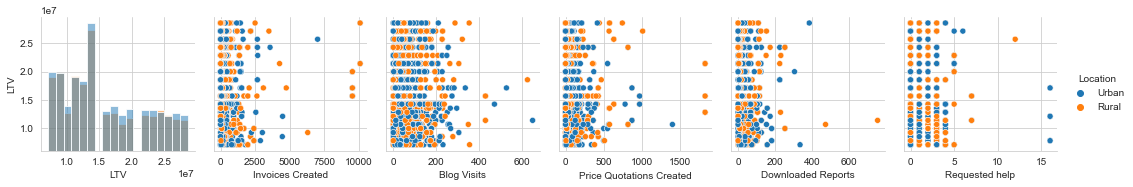

In [298]:
scatter('Location')

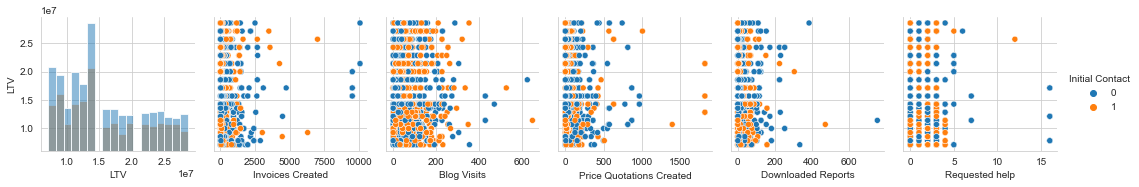

In [299]:
scatter('Initial Contact')

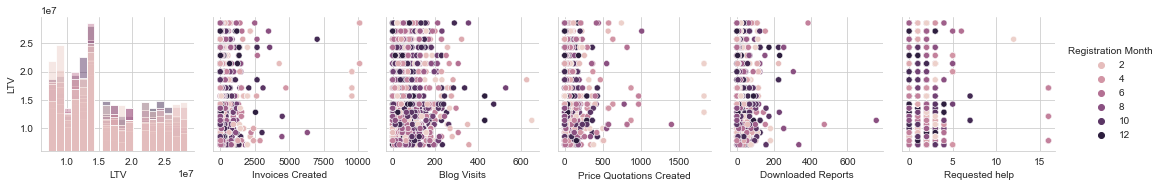

In [300]:
scatter('Registration Month')

From above scatter plots we cannot say much, there're not particular trends or clusters that indicate a dependency between the `LTV` values and the customer behaviour on demo plan.

We're going to try the conditional probability on `LTV` values to see if we can find something relevant for the followinf features:

- Invoices Created
- Blog Visits
- Additional users
- Registration Month
- Price Quotations Created
- Downloaded Reports

In [314]:
def churnPlot(df, param1, param2, par1lim, order=2):

    if par1lim is not None:
        dfC = df[df[param1] < par1lim].groupby(param1, as_index=False)[param2].mean()
    else:
        dfC = df.groupby(param1, as_index=False)[param2].mean()

    sns.lineplot(x=param1, y=param2, data=dfC)
    sns.regplot(x=param1, y=param2, data=dfC, order=order)

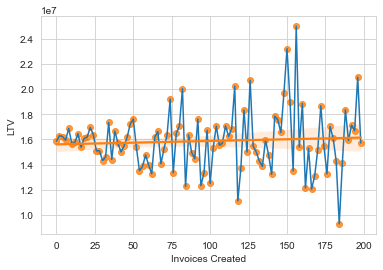

In [315]:
churnPlot(df_ltv, 'Invoices Created', 'LTV', 200, order=1)

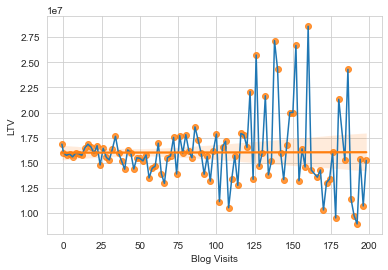

In [304]:
churnPlot(df_ltv, 'Blog Visits', 'LTV', 200, order=1)

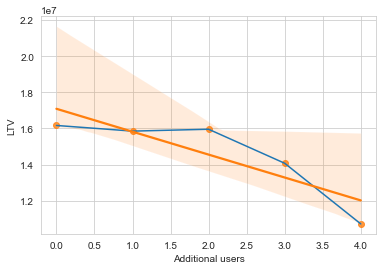

In [303]:
churnPlot(df_ltv, 'Additional users', 'LTV', None, order=1)

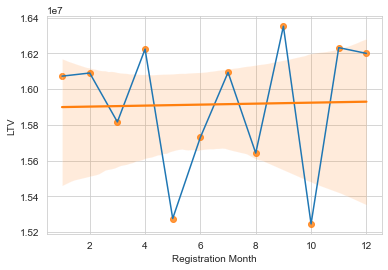

In [305]:
churnPlot(df_ltv, 'Registration Month', 'LTV', None, order=1)

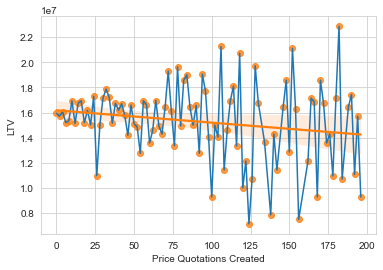

In [308]:
churnPlot(df_ltv, 'Price Quotations Created', 'LTV', 200, order=1)

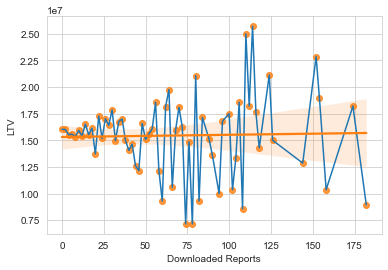

In [310]:
churnPlot(df_ltv, 'Downloaded Reports', 'LTV', 200, order=1)

There's no mucho dependency between the trial period features and the LTV values. Most of these cases show an slow increase on LTV values when increasing the feature value such as for `Invoices Created`, `Blog Visits`, `Registration Month` and, `Downloaded Reports`. However, those small increases fall way under the confidence level and therefore we can not trust these results. The only two relevant features are `Additional users` and `Price Quotations Created`. Results from `Additional users` shows a relation between high `LTV` values and a low number of additional users up to 2. `Price Quotations Created` us almost statistically flat but shows a small decrease on `LTV` values as this increase, meaning it's more likely to have high `LTV` values when users get smaller price quotations.